
# DNS Tunneling Detection with CNN + BiLSTM

This notebook trains a **DNS tunneling detection model** using a **hybrid CNN + BiLSTM architecture** on a preprocessed dataset:

- Input file: `dns_preprocessed_dataset_deduplicated.csv`
- Each row = one DNS packet
- Label:
  - `0` → normal DNS
  - `1` → tunneled DNS

The model uses:

- **Character-level encoding** of `qname_clean` as a sequence for CNN + BiLSTM
- **Numeric features** (length, entropy, etc.) as an auxiliary input
- Train/validation/test split
- Evaluation: accuracy, confusion matrix, classification metrics, and training curves


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping


## 1. Load and inspect dataset

In [ ]:

DATA_PATH = "/content/drive/MyDrive/Thesis_Dataset/dns_preprocessed_dataset_deduplicated1_(1).csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (3955, 12)


,qname,qname_len,label_count,qtype,qname_clean,entropy,udp_length,ip_length,ttl,response_flag,dns_time,label
0,mobile.events.data.microsoft.com,32,5,1,mobile.events.data.microsoft.com,3.804229,0,78,64,0,0.000000,0
1,mobile.events.data.microsoft.com,32,5,28,mobile.events.data.microsoft.com,3.804229,0,78,64,0,0.000000,0
2,mobile.events.data.microsoft.com,32,5,1,mobile.events.data.microsoft.com,3.804229,0,202,64,0,0.005787,0
3,mobile.events.data.microsoft.com,32,5,28,mobile.events.data.microsoft.com,3.804229,0,246,64,0,0.005768,0
4,mobile.events.data.microsoft.com,32,5,1,mobile.events.data.microsoft.com,3.804229,0,202,64,0,0.010284,0



Columns: ['qname', 'qname_len', 'label_count', 'qtype', 'qname_clean', 'entropy', 'udp_length', 'ip_length', 'ttl', 'response_flag', 'dns_time', 'label']

Label value counts:
label
1    2231
0    1724
Name: count, dtype: int64


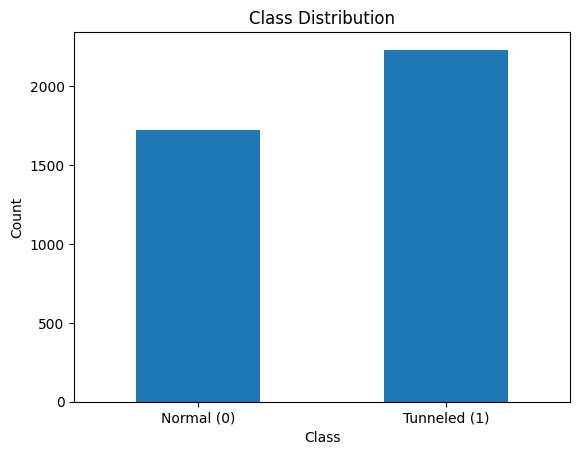

In [ ]:

print("\nColumns:", df.columns.tolist())
print("\nLabel value counts:")
print(df['label'].value_counts())

plt.figure()
df['label'].value_counts().sort_index().plot(kind='bar')
plt.xticks([0, 1], ['Normal (0)', 'Tunneled (1)'], rotation=0)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


### Quick look at qname length and entropy distributions

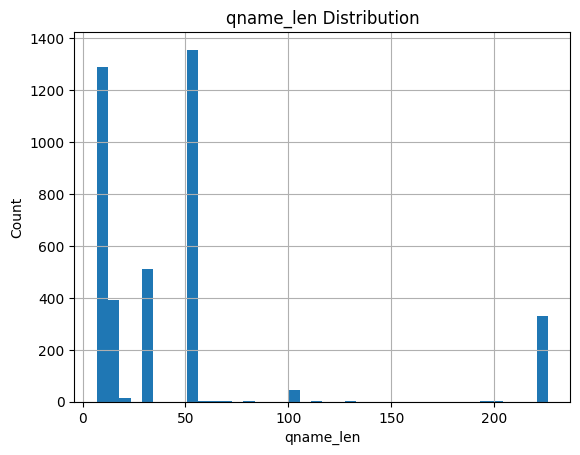

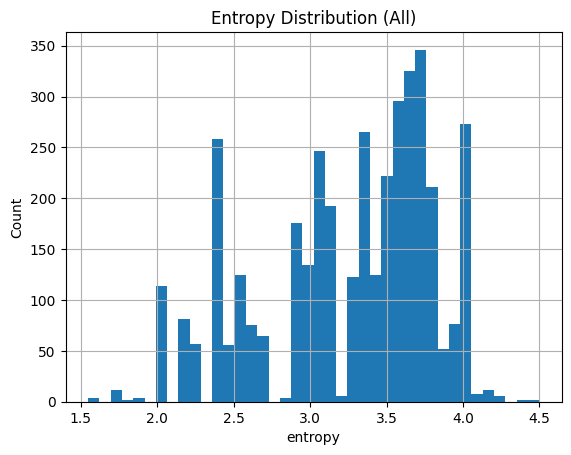

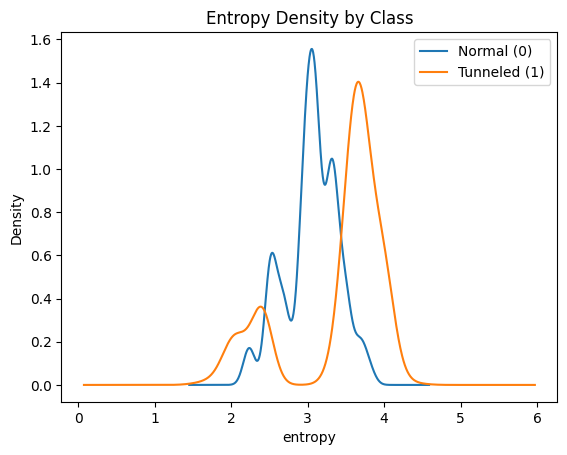

In [ ]:

plt.figure()
df['qname_len'].hist(bins=40)
plt.title('qname_len Distribution')
plt.xlabel('qname_len')
plt.ylabel('Count')
plt.show()

plt.figure()
df['entropy'].hist(bins=40)
plt.title('Entropy Distribution (All)')
plt.xlabel('entropy')
plt.ylabel('Count')
plt.show()

plt.figure()
df.groupby('label')['entropy'].plot(kind='kde')
plt.title('Entropy Density by Class')
plt.xlabel('entropy')
plt.legend(['Normal (0)', 'Tunneled (1)'])
plt.show()


## 2. Feature selection and preprocessing

In [ ]:

TEXT_COL = 'qname_clean'

NUMERIC_FEATURES = [
    'qname_len',
    'label_count',
    'qtype',
    'entropy',
    'udp_length',
    'ip_length',
    'ttl',
    'response_flag',
    'dns_time'
]

missing = [c for c in [TEXT_COL, 'label'] + NUMERIC_FEATURES if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

df = df[df[TEXT_COL].astype(str).str.len() > 0].copy()
df.reset_index(drop=True, inplace=True)
print("After dropping empty qname_clean rows:", df.shape)


After dropping empty qname_clean rows: (3955, 12)


### 2.1 Character vocabulary and sequence encoding

In [ ]:

all_text = ''.join(df[TEXT_COL].astype(str).tolist())
chars = sorted(list(set(all_text)))
print("Unique characters:", chars)
print("Vocab size (without special tokens):", len(chars))

char2idx = {c: i+1 for i, c in enumerate(chars)}
idx2char = {i+1: c for i, c in enumerate(chars)}

vocab_size = len(char2idx) + 1
print("Final vocab size (including padding):", vocab_size)

max_len_observed = df[TEXT_COL].astype(str).str.len().max()
MAX_SEQ_LEN = int(min(100, max_len_observed))
print("Max observed qname length:", max_len_observed)
print("Using MAX_SEQ_LEN:", MAX_SEQ_LEN)

def encode_qname(s, max_len=MAX_SEQ_LEN):
    s = str(s)
    seq = [char2idx.get(ch, 0) for ch in s[:max_len]]
    if len(seq) < max_len:
        seq = seq + [0] * (max_len - len(seq))
    return np.array(seq, dtype=np.int32)

X_text = np.stack(df[TEXT_COL].astype(str).apply(encode_qname).values)
print("X_text shape:", X_text.shape)


Unique characters: ['-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'O', 'Q', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', 'ž', 'Ǿ', 'ɾ', 'ʼ', '̿', ';', 'Ͼ', 'Ѽ', 'Ѿ', 'վ', 'پ', 'ܼ', 'ݼ', 'ݾ', '�']
Vocab size (without special tokens): 77
Final vocab size (including padding): 78
Max observed qname length: 205
Using MAX_SEQ_LEN: 100
X_text shape: (3955, 100)


### 2.2 Numeric features and scaling

In [ ]:

X_num = df[NUMERIC_FEATURES].astype(float).values
y = df['label'].astype(int).values

print("Numeric feature matrix shape:", X_num.shape)
print("Labels shape:", y.shape)

X_text_train, X_text_temp, X_num_train, X_num_temp, y_train, y_temp = train_test_split(
    X_text, X_num, y, test_size=0.3, random_state=42, stratify=y
)

X_text_val, X_text_test, X_num_val, X_num_test, y_val, y_test = train_test_split(
    X_text_temp, X_num_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", X_text_train.shape[0])
print("Val size:", X_text_val.shape[0])
print("Test size:", X_text_test.shape[0])

scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_val_scaled = scaler.transform(X_num_val)
X_num_test_scaled = scaler.transform(X_num_test)


Numeric feature matrix shape: (3955, 9)
Labels shape: (3955,)
Train size: 2768
Val size: 593
Test size: 594


## 3. Build CNN + BiLSTM model

In [ ]:

embedding_dim = 64
num_filters = 64
kernel_size = 5
lstm_units = 64
dense_units = 64

text_input = Input(shape=(MAX_SEQ_LEN,), name="text_input")
x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_SEQ_LEN)(text_input)
x = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Bidirectional(layers.LSTM(lstm_units))(x)
x = layers.Dense(dense_units, activation='relu')(x)

num_input = Input(shape=(X_num_train_scaled.shape[1],), name="num_input")
n = layers.Dense(32, activation='relu')(num_input)
n = layers.Dense(32, activation='relu')(n)

combined = layers.concatenate([x, n])
combined = layers.Dense(64, activation='relu')(combined)
output = layers.Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[text_input, num_input], outputs=output)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │      4,992 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 96, 64)    │     20,544 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 48, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     66,048 │ max_pooling1d[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        320 │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,056 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 107,489 (419.88 KB)

 Trainable params: 107,489 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the model

In [ ]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    [X_text_train, X_num_train_scaled], y_train,
    validation_data=([X_text_val, X_num_val_scaled], y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.7992 - loss: 0.4468 - val_accuracy: 1.0000 - val_loss: 5.5724e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9988 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9978 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 4.9839e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9978 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss: 2.2260e-04
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 1.0000 - loss: 4.6264e-04 - val_accuracy: 0.9983 - val_loss: 0.0022
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9990 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 5.5401e-04
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 5.6425e-04
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.9999 - loss: 9

### 4.1 Training and validation curves

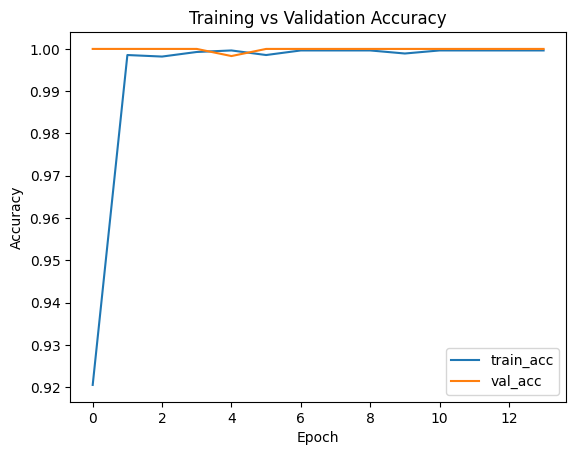

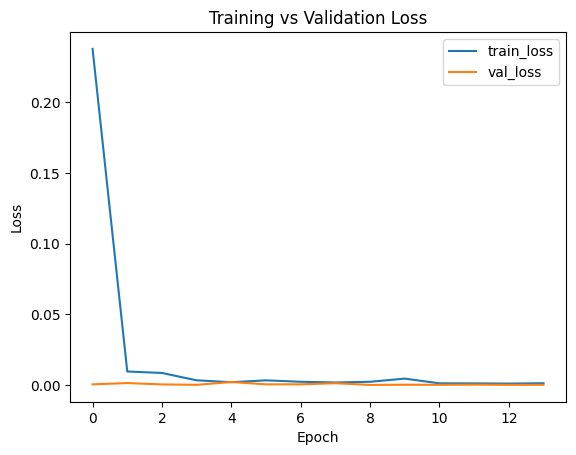

In [ ]:

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 5. Evaluation on test set

In [ ]:

test_probs = model.predict([X_text_test, X_num_test_scaled]).flatten()
test_preds = (test_probs >= 0.5).astype(int)

print("Classification report:")
print(classification_report(y_test, test_preds, digits=4))

cm = confusion_matrix(y_test, test_preds)
cm


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Classification report:
              precision    recall  f1-score   support

           0     0.9962    1.0000    0.9981       259
           1     1.0000    0.9970    0.9985       335

    accuracy                         0.9983       594
   macro avg     0.9981    0.9985    0.9983       594
weighted avg     0.9983    0.9983    0.9983       594



array([[259,   0],
       [  1, 334]])

### 5.1 Confusion matrix

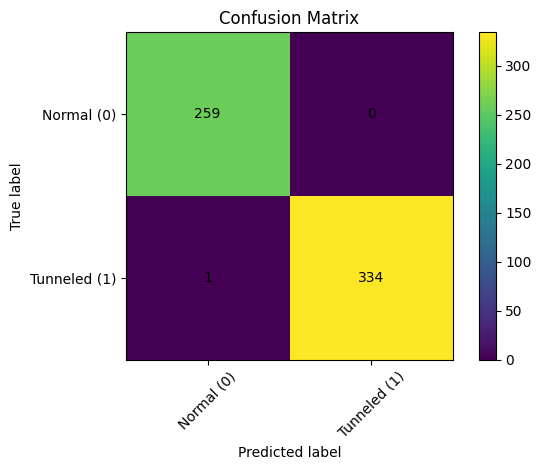

In [ ]:

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal (0)', 'Tunneled (1)'], rotation=45)
plt.yticks(tick_marks, ['Normal (0)', 'Tunneled (1)'])

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


### 5.2 ROC curve

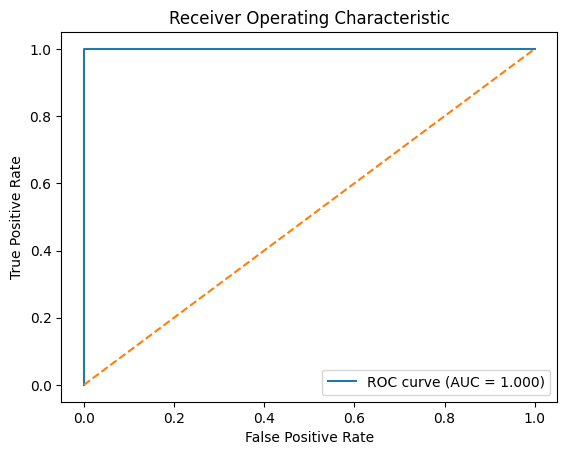

In [ ]:

fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


## 6. (Optional) Save model

In [ ]:

MODEL_PATH = "dns_cnn_bilstm_model.h5"
model.save(MODEL_PATH)
print("Model saved to:", MODEL_PATH)


Model saved to: dns_cnn_bilstm_model.h5
